# CA3 — EKF-SLAM Analysis Questions

1. Which path leads to lower pose error and lower map uncertainty by the end?

I made two main control paths, one greedy path where landmarks with covariance trace below *well_mapped_threshold* are considered sufficiently mapped and ignored.  When every known landmark is well-mapped (or none have been seen yet), the robot switches to an exploration arc so it can discover new landmarks by traveling towards the center. 
The other control path functions more as an explore and wander strategy, traveling towards observed landmarks, then randomly choosing a direction to explore to find another landmark by driving straight. Bounces off environment walls by steering toward the centre. As soon as the EKF detects a new (unvisited) landmark, it transitions to seek, where it steers toward the landmark. Then it explores, where the robot counter-clockwise orbits around the landmark for 100 time-steps, gathering close-range measurements to reduce covariance. After orbiting, it marks the landmark as "visited" and returns to WANDER with a fresh random heading.

The **greedy** path produced highly variable pose error across runs, with its best run achieving the lowest mean pose error of 0.2154 m. But final landmark uncertainty plateaued around an average trace of 0.21. The **landmark_hop** path had a moderate mean pose error of 0.3939 m but achieved significantly lower map uncertainty, with an average landmark trace of 0.1453 at step 350 and a tighter per-landmark spread. So greedy can win on pose error in a lucky run, but landmark_hop consistently produces a better-mapped environment with lower and more uniform landmark uncertainty.

2. How do the uncertainty ellipses for landmarks behave over time under each path?

Under the **greedy** path, landmark ellipses shrink steadily but unevenly. Landmarks near the robot's recurring arc get very tight ellipses quickly, while peripheral landmarks remain large because the greedy controller stops revisiting them once their trace drops below the threshold. Under the **landmark_hop** path, ellipses shrink more uniformly across all landmarks because the orbiting phase dedicates around 100 close-range observation steps to each landmark in turn.


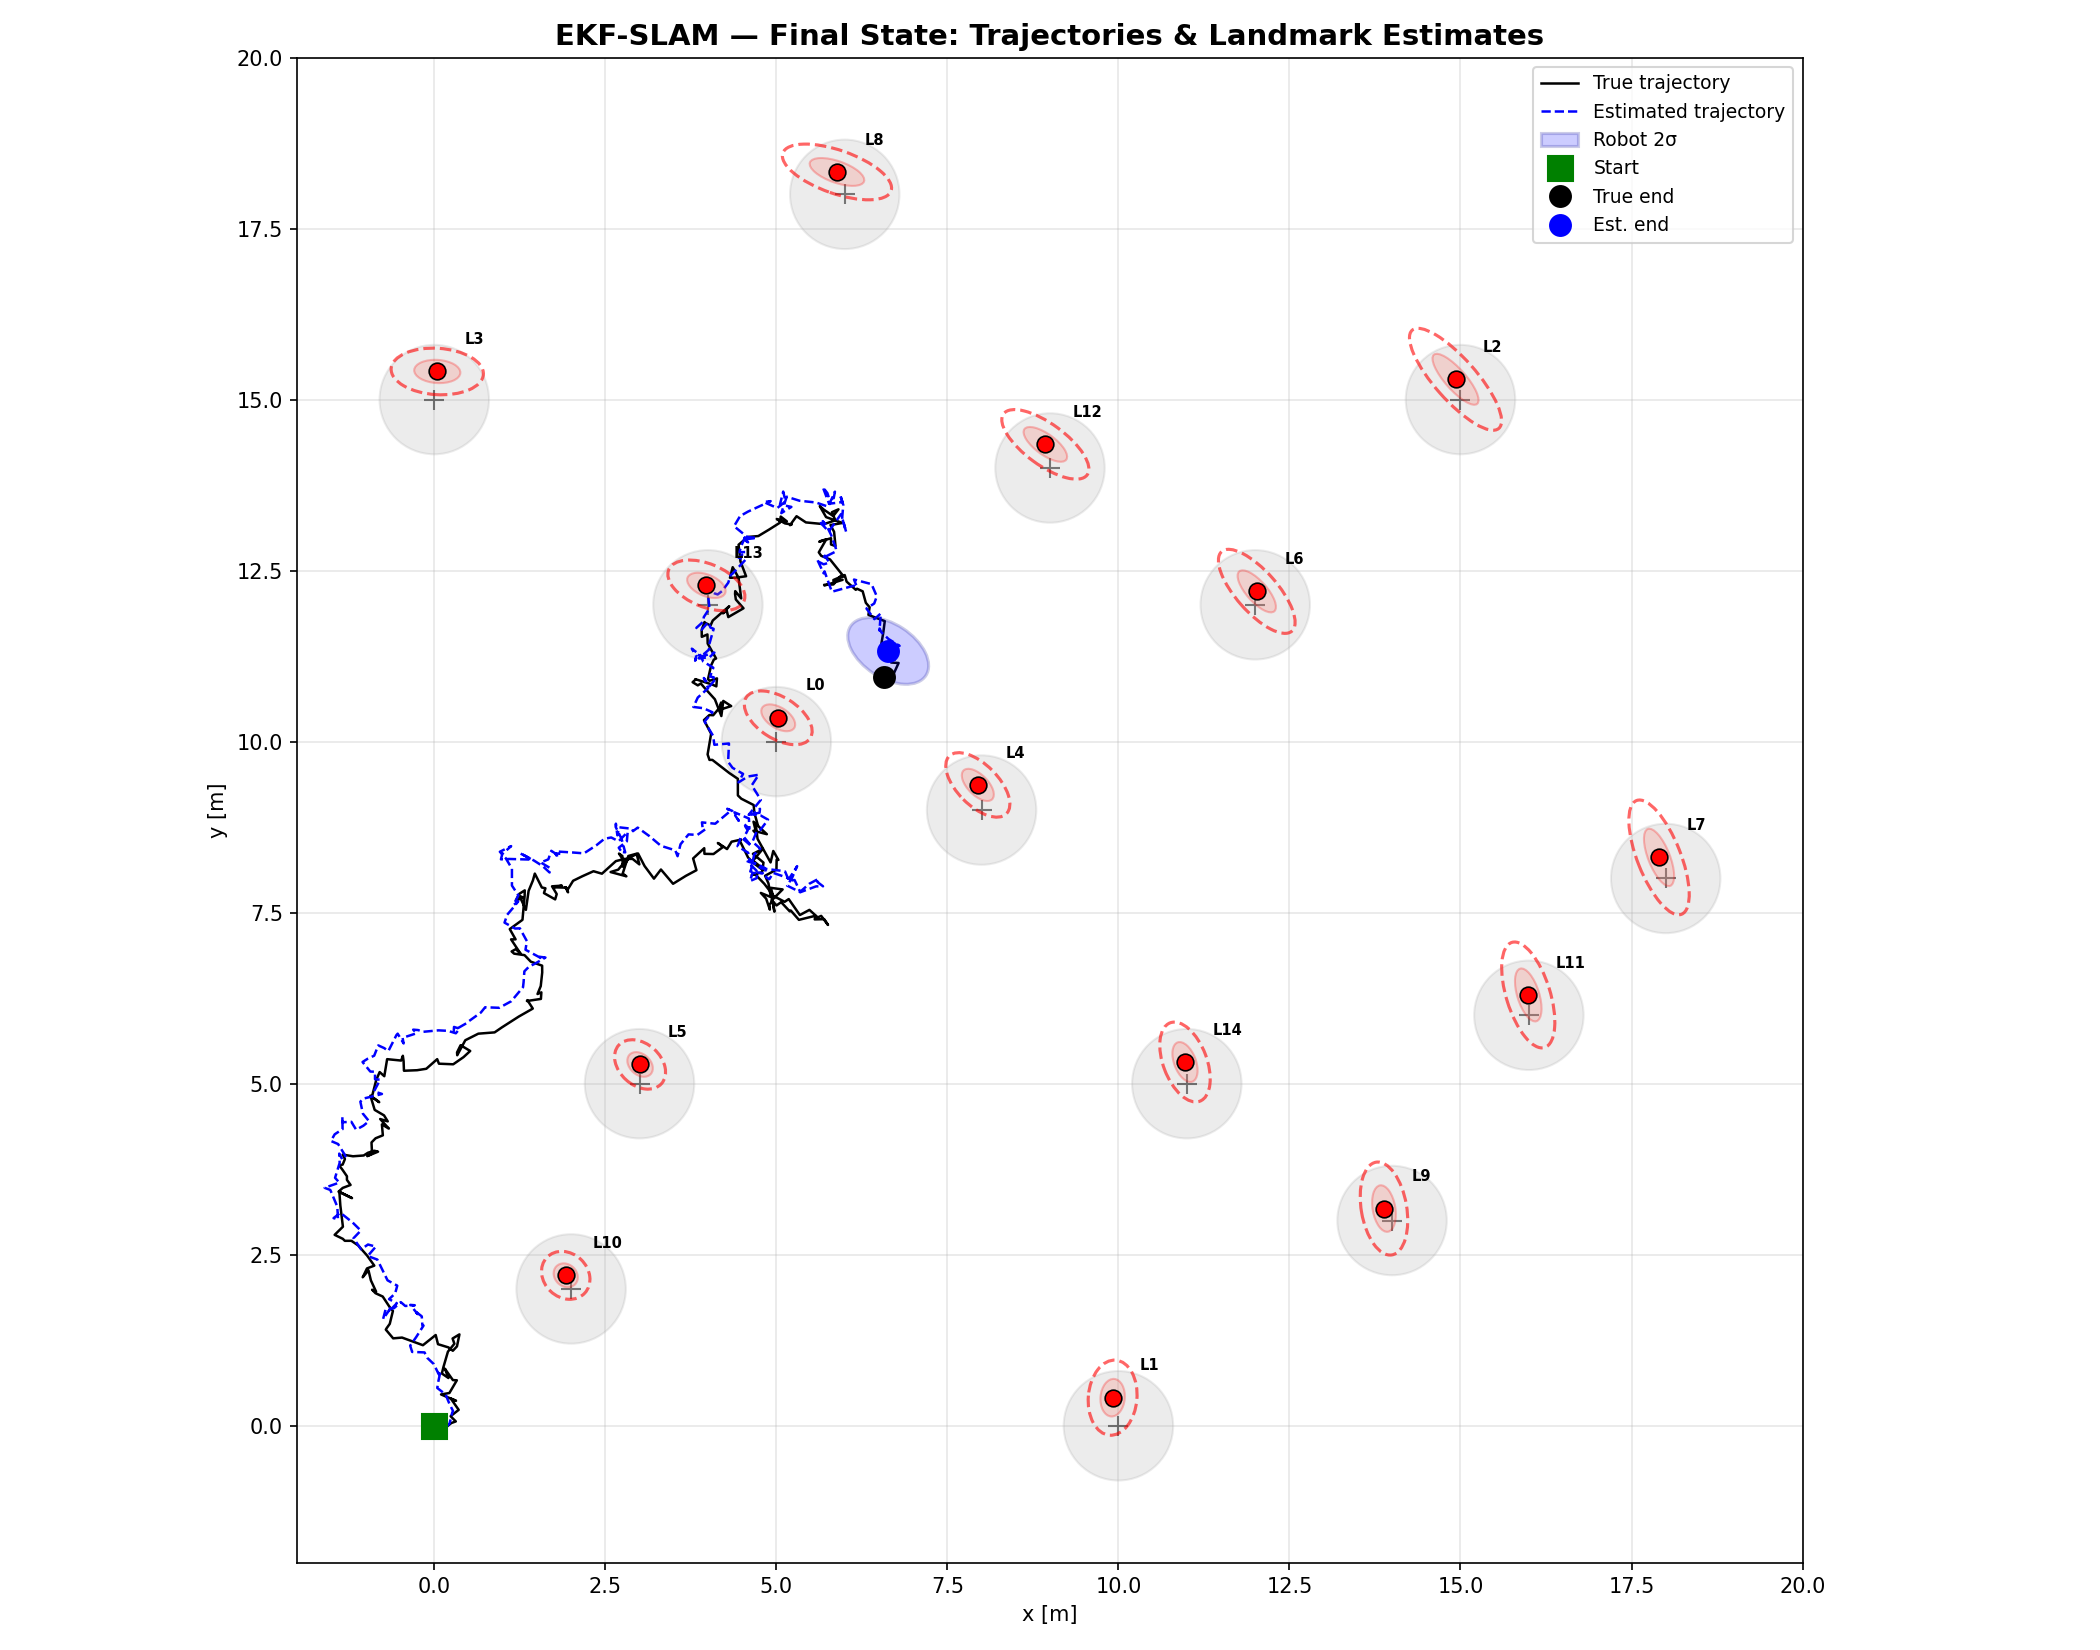

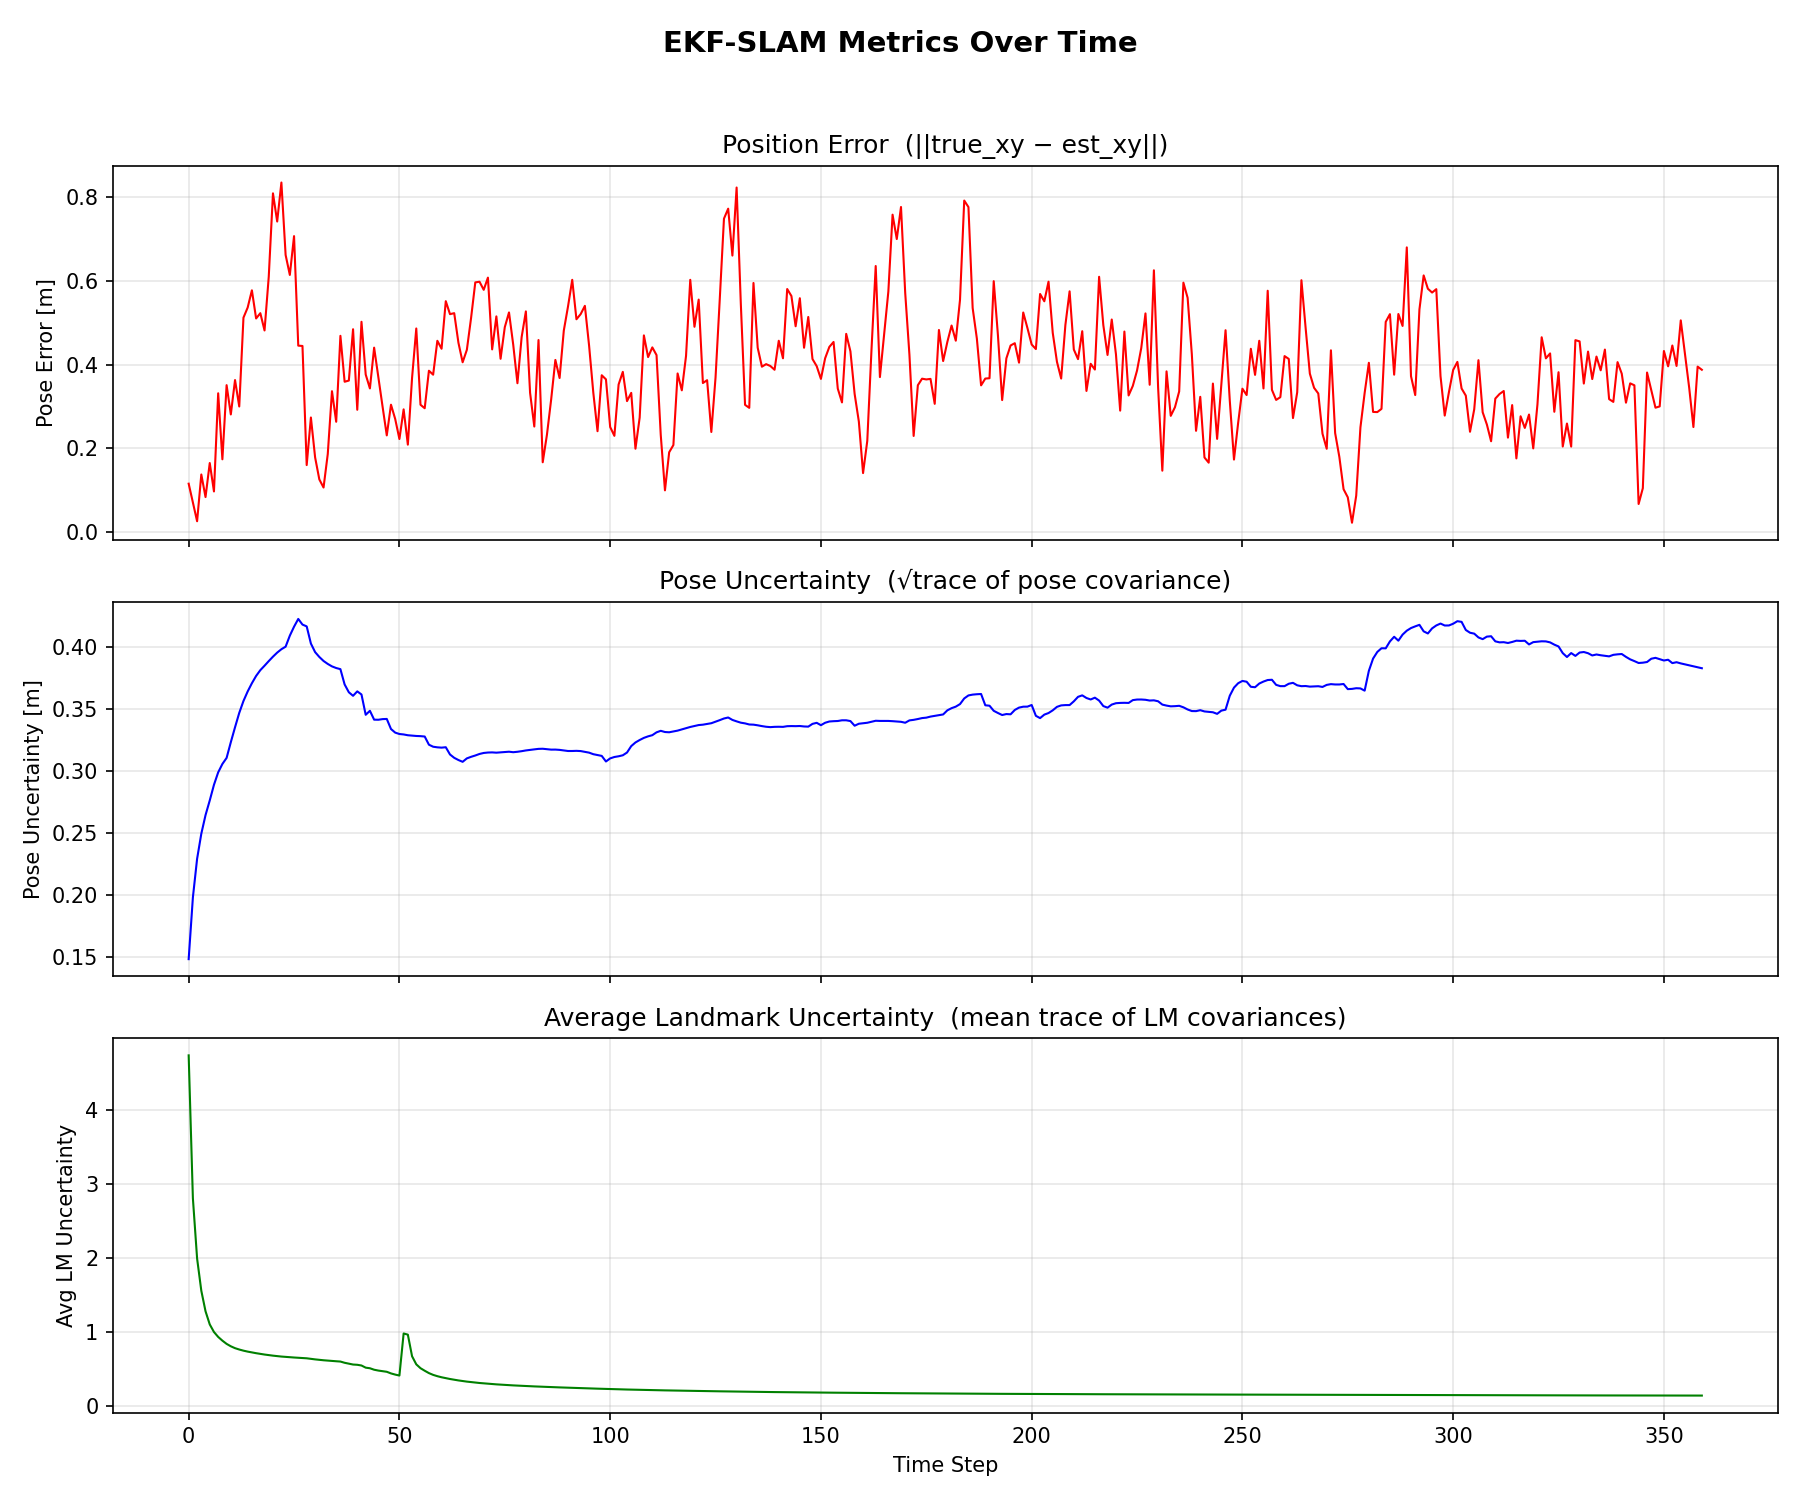

3. Give at least one concrete example (with a figure) where the robot revisits an area and uncertainty clearly shrinks. Explain what's happening in terms of EKF-SLAM.


In the landmark_hop run, **landmark L4** (at position [8, 9]) provides a clear example. At step 50 the robot has just discovered L4 and its trace is high. By step 100, after the controller orbited L4 and moved on, L4's trace dropped to 0.1104 — a 74% reduction. Later in the run, as the robot seeks other landmarks in the same neighbourhood (L0, L12, L6), it passively re-observes L4 from varying angles, and L4's final trace settles at 0.1104, the lowest of the central landmarks. In the EKF, each new measurement of L4 triggers the correction step, mapping a state update. Every additional observation tightens the 2×2 landmark covariance block, visibly collapsing the ellipse. 

## A.2 Noise Sensitivity 

How does increasing motion noise vs increasing measurement noise affect:

- **Pose accuracy:** Increasing process noise R raises mean pose error moderately 0.32 to 0.47 m, while increasing measurement noise Q raises it dramatically  from 0.12 to 1.03 m. At high Q the maximum per-step error reaches 1.87 m.
- **Map accuracy:** Landmark uncertainty grows 3 times larger as R increases vs 3.9 times larger as Q increases, but the mean over time jumps from 0.11 to 1.02 with high Q, which is terrible.
- **Overall uncertainty:** Pose uncertainty triples under each sweep's worst case, but the error-to-uncertainty ratio is better calibrated at a higher R, which I think is due to the filter's own prediction covariance growing in step with the actual noise. Under high Q, the correction step itself is noisy, so the filter's confidence is too tight and poorly informed.

**Which type of noise is more damaging?** Measurement noise Q is more damaging. When Q is large, every correction step carries unreliable information, degrading both pose and map with no compensating ability.

**Does the landmark-hop trajectory still perform well under higher noise?** Yes, it still discovers all 15 landmarks at every noise level, and it degrades gracefully: even at high R the final average landmark uncertainty is well below where the greedy controller lands at medium noise. The orbiting behaviour that collects many close-range observations counters the additional noise. However, at high Q the landmark-hop controller's final pose error is substantially larger, so performance does drop, but less dramatically than a controller that does not systematically revisit landmarks.

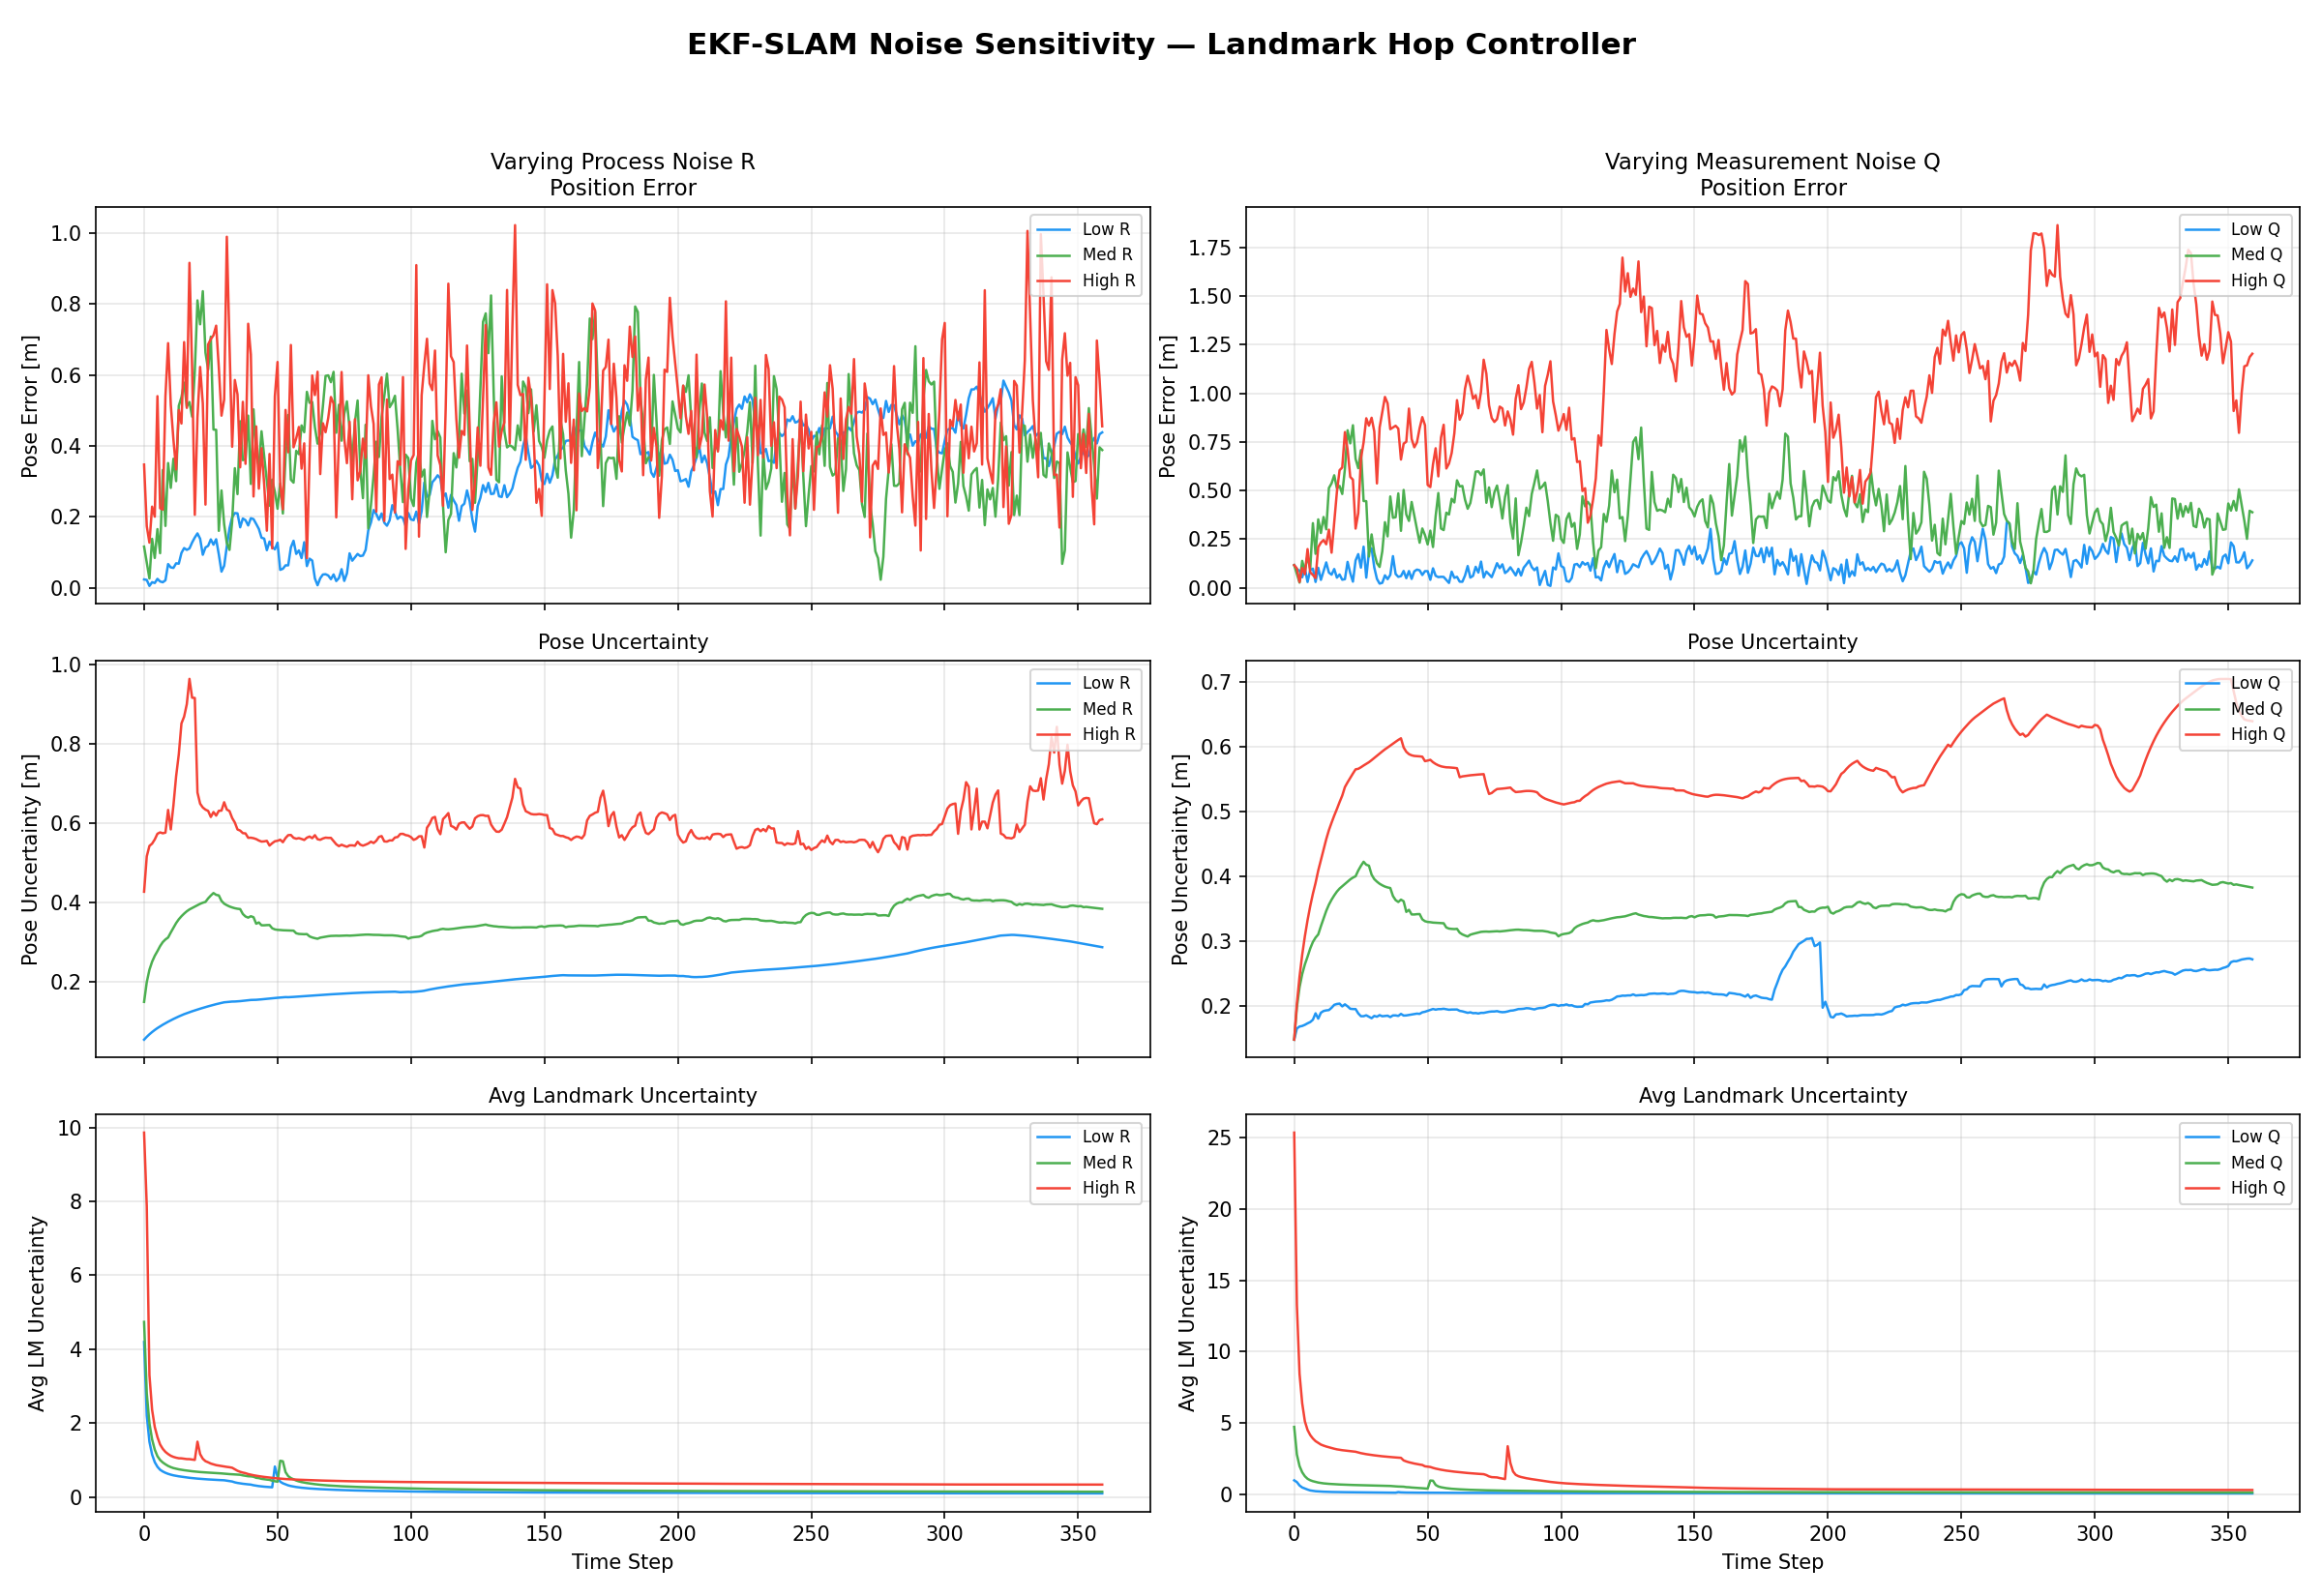

## Part B – PRM vs RRT: Planning in the Same Environment

### The two scenarios proposed: 
scenario 1: start/goal position that force one possible path because there's obstacles blocking any other possible path
scneario 2: start/goal position that force the path to make several tight and narrow turns

**Prediction**: In both scenarios, I think the RRT algorithm should perform better because in scenario 1, since the RRT can be biased towards the goal, it would find the singular path to the goal faster as there isn't any need to find an optimal path, just a singular path. For scenario 2, PRM requires more samples to navigate tight corners because its unlikely for random sampling to hit the small area that allows for turning.

**Results**

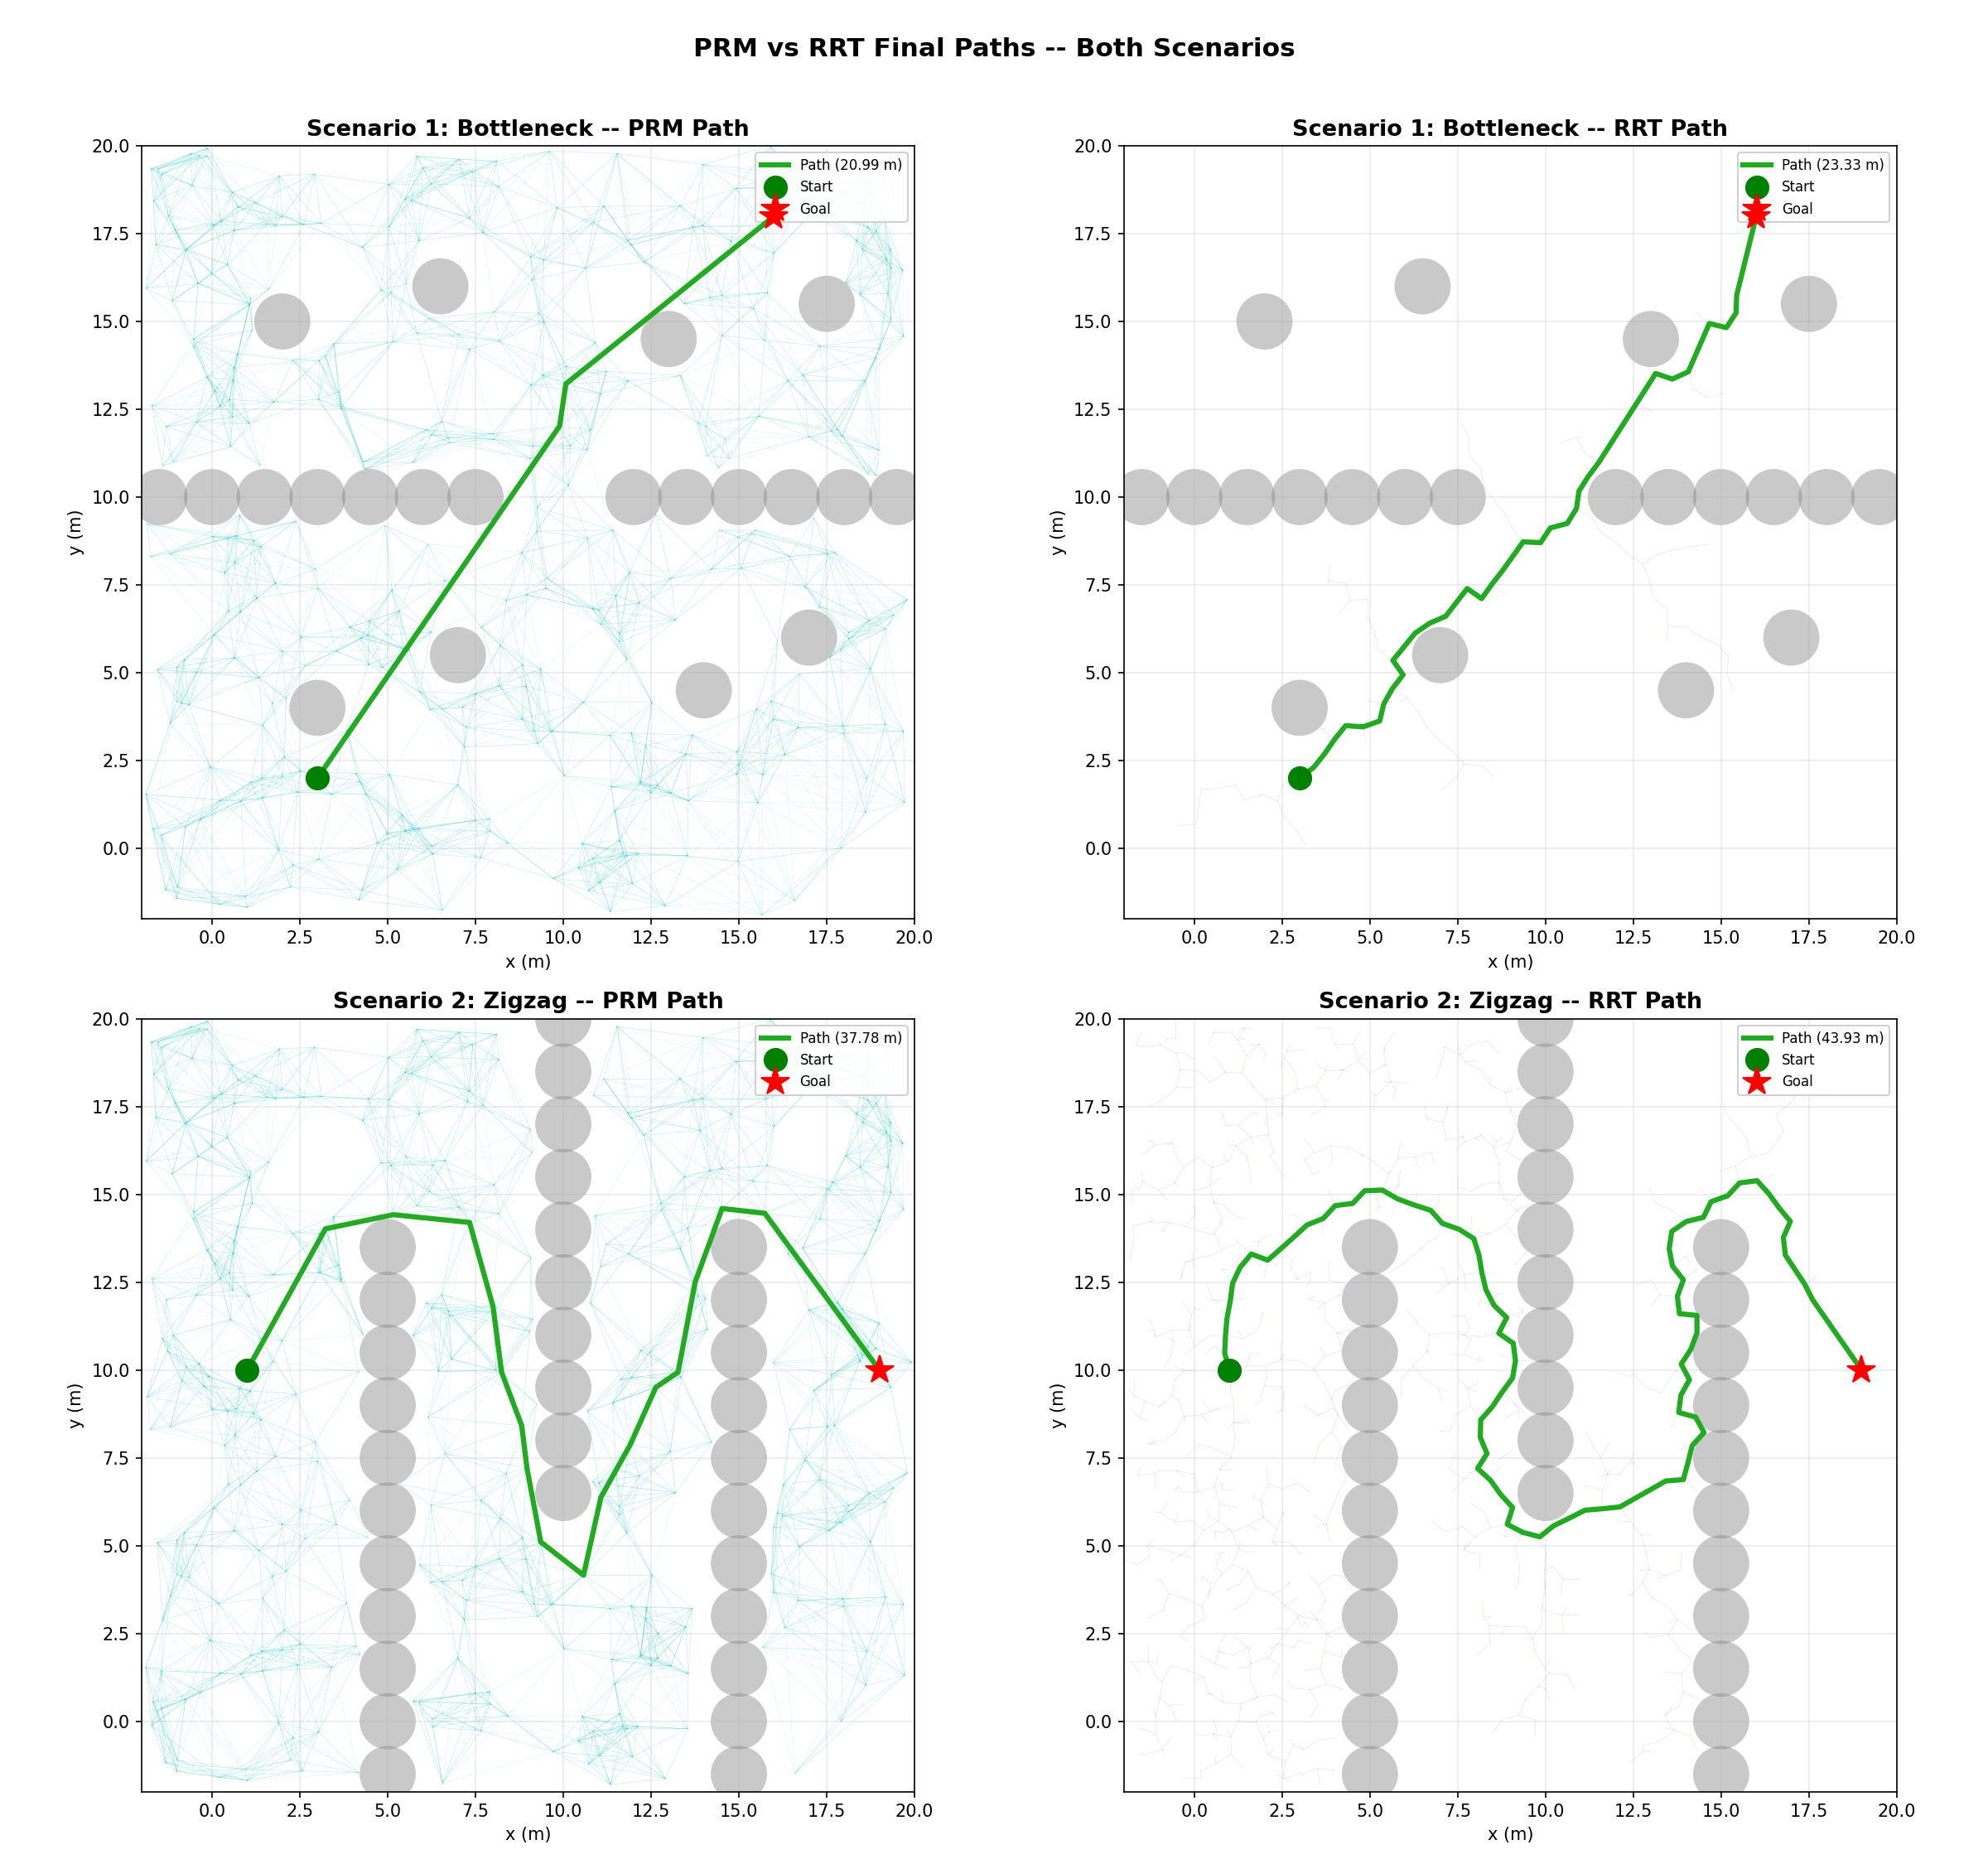

In [ ]:
=================================================================
  Scenario1_Bottleneck -- Multi-Trial Summary
=================================================================
Metric                                   PRM             RRT
------------------------------------------------------------
Trials                                    20              20
Successes                                 20              20
Success rate (%)                      100.0%          100.0%
Mean path length (m)                   20.86           25.00
Std  path length (m)                    0.06            0.93
Mean time (s)                         2.4118          0.0534
Std  time (s)                         0.0606          0.0386
Mean smoothness (rad)                 0.3382          0.5187
Mean nodes created                     400.0           171.0
=================================================================
=================================================================
  Scenario2_Zigzag -- Multi-Trial Summary
=================================================================
Metric                                   PRM             RRT
------------------------------------------------------------
Trials                                    20              20
Successes                                 20              20
Success rate (%)                      100.0%           80.0%
Mean path length (m)                   38.91           50.35
Std  path length (m)                    1.99            2.37
Mean time (s)                         2.9759          2.1565
Std  time (s)                         0.0465          0.5240
Mean smoothness (rad)                 0.5853          0.5663
Mean nodes created                     400.0          1233.4
=================================================================

The RRT planner had a higher success rate, however the PRM produced shorter paths as expected. Oddly, the PRM was able to create shrper turns around obstacles than RRT. No failure modes.

## B3 Parameter Studies
All trials in PRM and RRT resulted in success regardless of how samples changed. The path length decreased across al k_neighbor values as samples increased. The Computation time linearly increased from 1 second to 2-6 depending on the k value, with k=20 taking the longest. For k=10, more samples didn't help shorten the path length.

step size in RRT made solution speed significantly faster by over 50%, however greater step sizes than 0.5 either forced the computation time to plateau or increase again. The path qulity varied depending on the set goal sample rate, where g=0.0 was attibuted with a longer path length as step size increased, but g=0.3 led to no improvement in path length past step size of 0.5. Step size does not improve path quality and misses narrow passages in some cases.

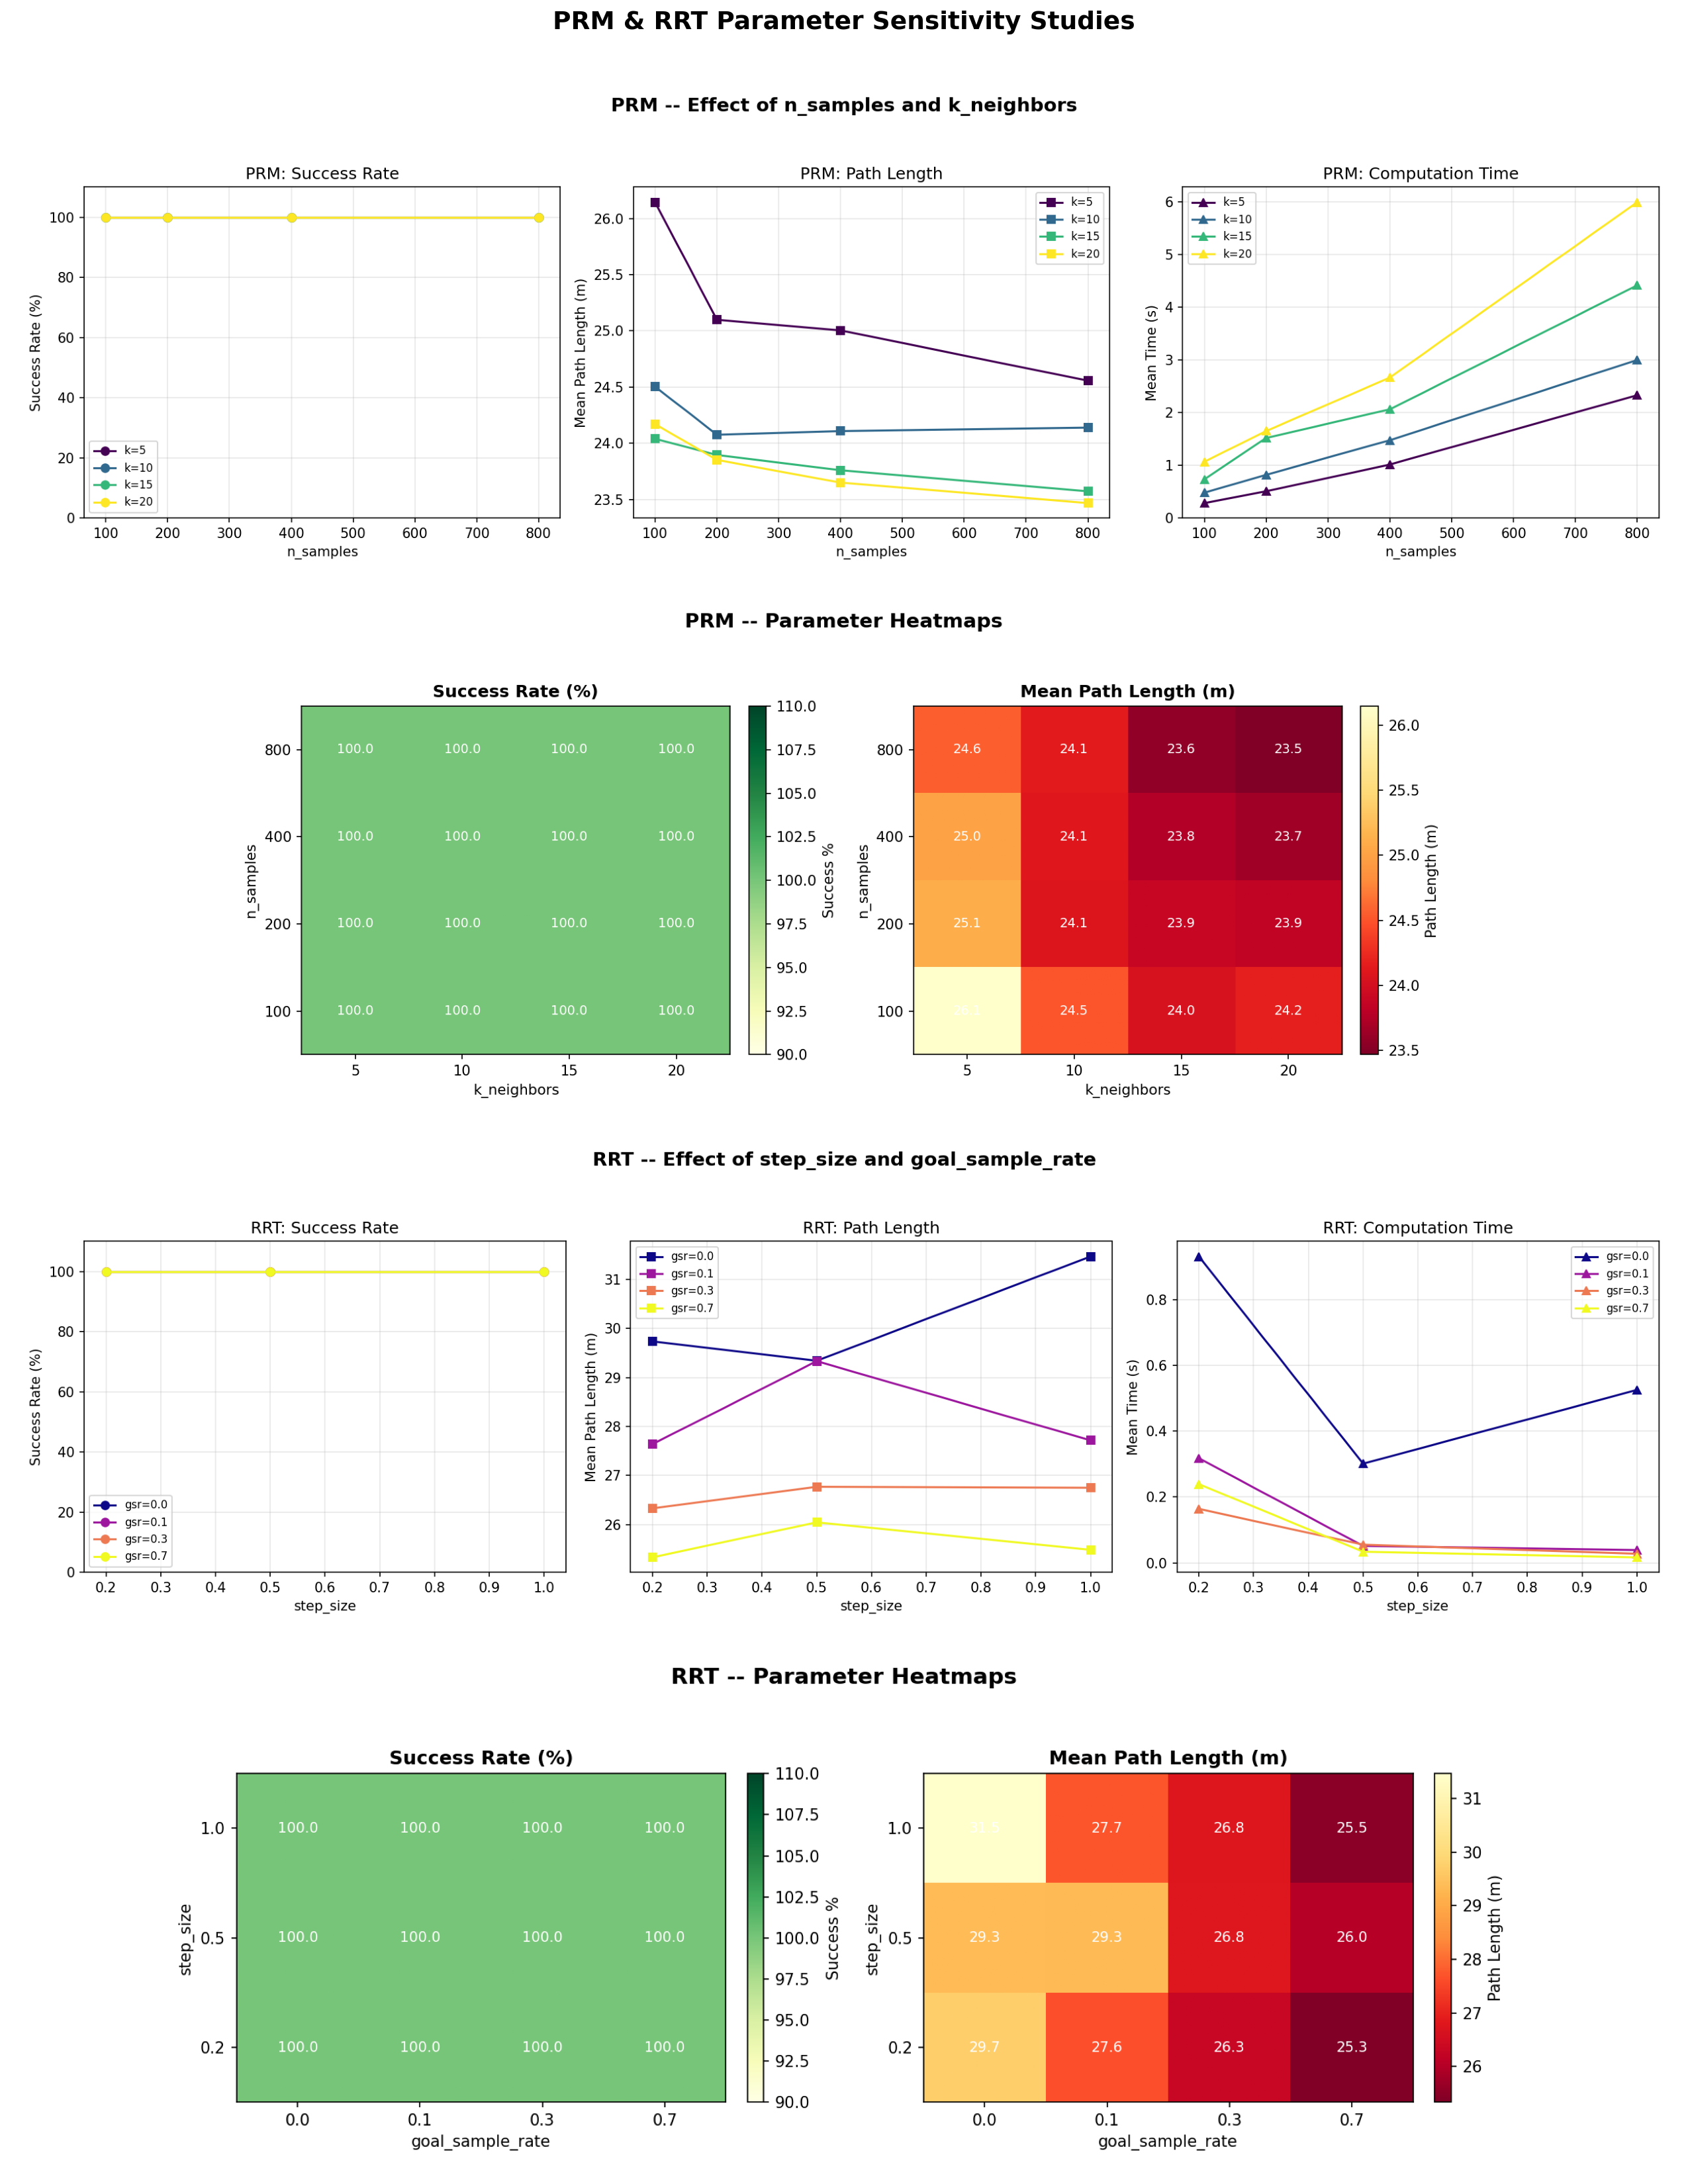

## Improving PRM and RRT

1. I implemented path post-processing for PRM and path smoothing for RRT.
2. It was tested over a map that contained several obstacles to create a cluttered area. 
3. In the improved PRM, the path length decreased neglibly, hwoever for RRT the path length decreased by 3 meters. The waypoints in PRM reduced 3x, and for RRT the waypoints were reduced by a drastic factor of 10. The time it took for PRM to complete remained the same, however for RRT the improved version took longer, which makes sense because path smoothing adds on another shortcutting procedure that costs more time. The smoothness of the PRM path improved by a factor of 2, while for the RRT path the smoothness slightly decreased.
5. This improvement behaved as I expected for path length because for both RRT and PRM the paths were more direct and curved to create tight turns. I expected the RRT waypoints to decrease drastically as it avoided the other potential tree branches that are formed on the path found, which of course costs more time to create as I expected because another layer of complexity is added to iterate over our found path to smoothen it out. I did not expected the smoothness to decrease for the improved RRT path, but i believe this is negligable as the paths look identical to me.


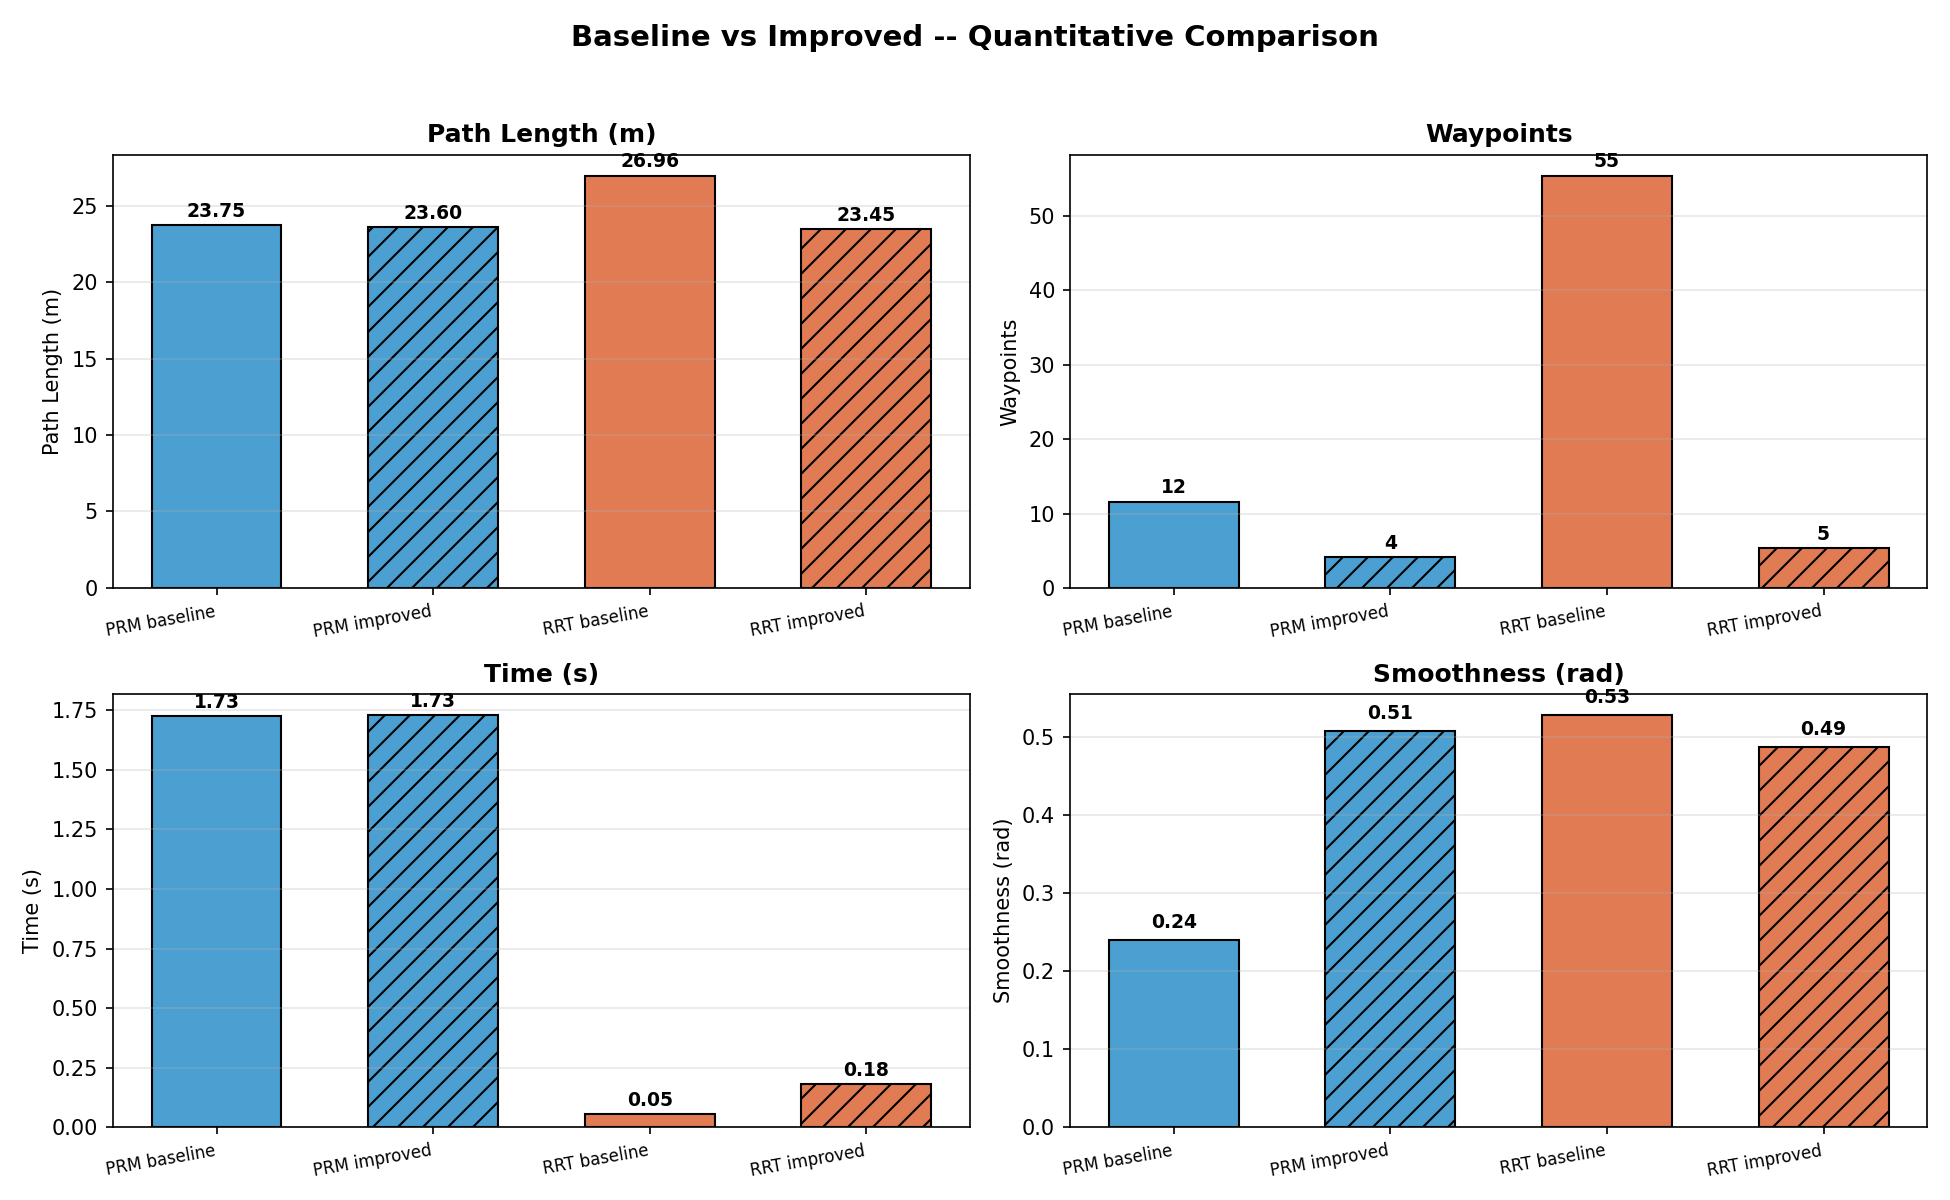

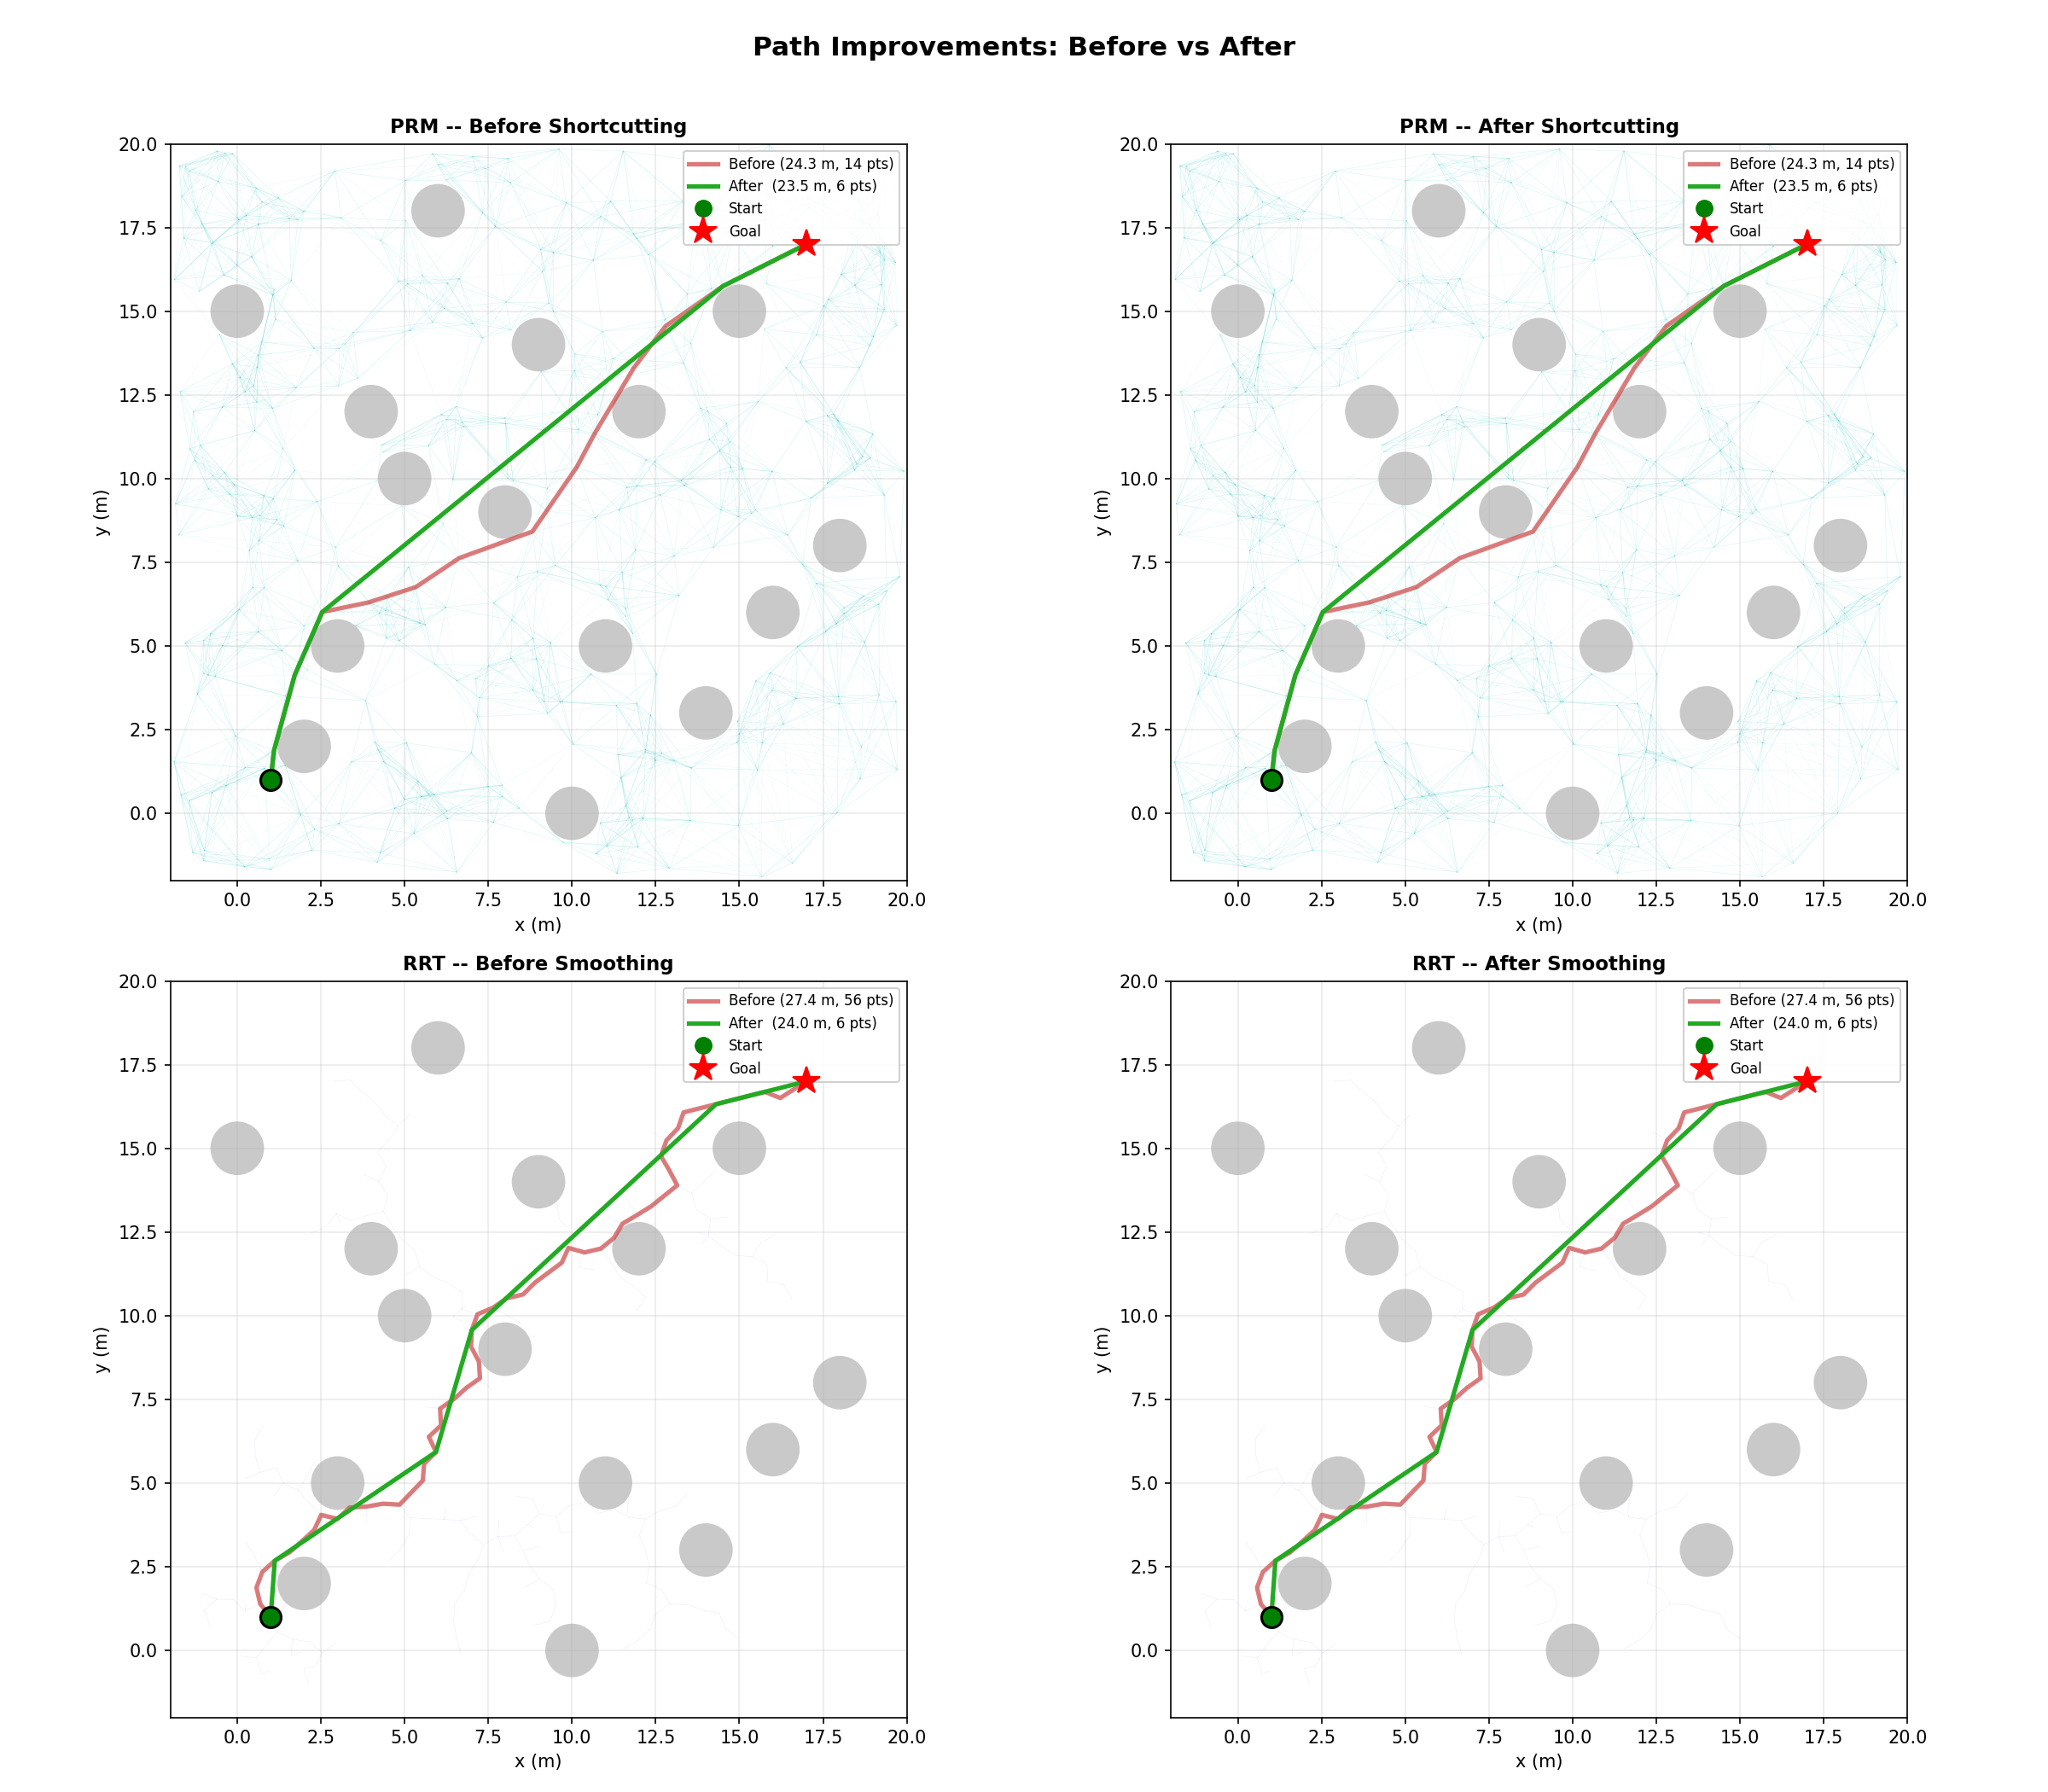

## Brief Description of Parts A-C
Basically, for every part, I asked Cursor to generate an experiment script, logistical analysis summing up the iterations of each experiment, and 1-2 images that captured the EKF-SLAM/Planning outputs for comparison. I then wrote my responses based off of that output when the experiment script was run.

## How AI was Used


 I used Cursor to generate all tables, plots, and experimental code, giving a description of what I was trying to achieve and the steps that needed to be taken for it to be achieved. For analysis, I asked the AI agent to provide plots and tables highlighting specific metrics from terminal/experiment script output.